# MASTML

In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
import matplotlib.pyplot as plt
import random
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.models import SklearnModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel
import time

XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal


## Load Data

In [2]:
pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

# LOAD DATA
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

# PARSE DATA
x_clean = data[['composition', 'structure', 'space group']]
compositions = x_clean['composition']
# structure = x_clean['structure']
print("num compositions", len(compositions))

num compositions 74992


In [3]:
# subset n random values
comp_zip_y = list(zip(compositions, data_y.T.values.tolist()[0]))

## Functions

In [4]:

def create_subset(sample_from, n=1000):
    """Creates subset of size `n`"""
    subset_compositions, subset_y = zip(*random.sample(sample_from, n))
    subset_x = pd.DataFrame(subset_compositions)
    return subset_x, subset_y


def vectorize(x_compositions, y):
    """Computes elemental features and applies normalization"""
    e_features = ElementalFeatureGenerator(x_compositions)
    e_features.fit()

    feat_x, feat_y = e_features.transform()

    x = feat_x

    # Scale
    preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
    x = preprocessor.evaluate(X=x, y=y)

    return x, y


def compute_elemetal_fractions(x_compositions):
    """Computes elemental fractions"""
    e_fraction = ElementalFractionGenerator(x_compositions)
    e_fraction.fit()
    frac_x, frac_y = e_fraction.transform()  # only used to create domains later
    return frac_x, frac_y


def featurize(x, y, n=25):
    """With random forest choses top `n` features"""
    model = SklearnModel(model='RandomForestRegressor')
    selector = EnsembleModelFeatureSelector(model=model, n_features_to_select=n)
    x = selector.evaluate(X=x, y=y)
    return x


def rmse(predictions, targets):
    """Root mean square error"""
    return np.sqrt(((predictions - targets) ** 2).mean())


def showScores(x, y, y_, gpr, std):
    """Show evaluation metrics given `x`, `y`, and predicted y, `y_` and GPR model `gpr`"""

    r2_score = gpr.score(x, y)
    print(f"R^2 score: {r2_score}")
    print(f"rmse", rmse(y, y_))
    err = rmse(y, y_) / np.std(y)
    print(f"R^2 score / std: {err}")
    print(f"Uncertainty mean: {np.mean(std)} std: {np.std(std)}")

    # performance graph
    max_val = max(max(y), max(y_))
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    ax.set_xlim((0, max_val))
    ax.set_ylim((0, max_val))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()

    # uncertainty graph
    plt.hist(std)
    plt.show()


def fit_gpr(x, y):
    """Given `x` and `y` returns a trained GPR model"""

    gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)

    print("Start fitting")
    stime = time.time()

    gpr.fit(x, y)

    print("Done. Time for GPR fitting: %.3f" % (time.time() - stime))
    return gpr


## One Run

In [5]:
# # Subset
# subset_x, subset_y = create_subset(comp_zip_y, n=1000)
# # Vectorize
# x, y = vectorize(subset_x, subset_y)
# # Featurize
# x = featurize(x)
# # Fit GPR
# gpr = fit_gpr(x, y)
# # Predict
# y_, std_ = gpr.predict(x, return_std=True)
# # Score
# # showScores(x, y, y_, gpr, std_)

In [6]:
# # Compute domain assesment
# # Split x and y by domains using frac_x
# frac_x, _ = compute_elemetal_fractions(subset_x)

# element = "O"
# threshold = 0
# subset_y_df = pd.DataFrame(subset_y)
# g1 = frac_x[frac_x[element] <= threshold]
# g1_y = subset_y_df[frac_x[element] <= threshold]
# g2 = frac_x[frac_x[element] > threshold]
# g2_y = subset_y_df[frac_x[element] > threshold]

## Run to test domains

In [7]:
# # create subsets such that there is enough training (at least 500)
# subset_x = subset_y = frac_x = None
# n = 2000
# element = "O"
# threshold = 0
# min_train_group = 500

# for i in range(1000):
#     # create subset
#     subset_x, subset_y = create_subset(comp_zip_y, n=n)
#     # from subset create domains
#     frac_x, _ = compute_elemetal_fractions(subset_x)
#     g1_ = frac_x[frac_x[element] <= threshold]

#     if len(g1_) >= min_train_group:
#         break
#     n *= 1.1
#     n = int(n)

# # Vectorize
# x, y = vectorize(subset_x, subset_y)

# # Featurize
# x = featurize(x)

In [8]:
# # create groups
# subset_y_df = pd.DataFrame(subset_y)
# g1 = x[frac_x[element] <= threshold]
# g1_y = subset_y_df[frac_x[element] <= threshold]
# g2 = x[frac_x[element] > threshold]
# g2_y = subset_y_df[frac_x[element] > threshold]

# # train GPR on in-domain
# gpr_domain = fit_gpr(g1, g1_y)

# # test on in-domain, out-domain, all
# y_in, std_in = gpr_domain.predict(g1, return_std=True) # in-domain
# y_out, std_out = gpr_domain.predict(g2, return_std=True) # out-domain
# y_all, std_all = gpr_domain.predict(x, return_std=True) # all

In [9]:
# in-domain
# showScores(g1, g1_y, y_in, gpr_domain, std_in)
# out-domain
# showScores(g2, g2_y, y_out, gpr_domain, std_out)
# all
# showScores(x, y, y_all, gpr_domain, std_all)

## Test physical groups

In [61]:
def test_domain(comp_zip_y, n = 2000, element = ["O"], threshold = 0, min_train_group = 500, min_test_group = 1, max_n = 1000, max_tries=1000, dynamic_threhold=False, dynamic_match=False, num_match=1):
    """Runs all steps: subset, vectorize, fit, test. Then test in-domain, out-domain, and all for a subset of the data given in the list of tuples `comp_zip_y` which is (composition, y-value)"""
    # TODO: Should probably add a min_test_group as well, and/or combine that with the min_train_group metric. Might have to dynamically change n
    # create subsets such that there is enough training (at least min_train_group)
    subset_x = subset_y = frac_x = None

    print("Create valid subsets")
    for i in range(max_tries):
        # create subset
        subset_x, subset_y = create_subset(comp_zip_y, n=n)
        # from subset create domains
        frac_x, _ = compute_elemetal_fractions(subset_x)

        # array of boolean arrays of same length as frac_x to choose what rows are in each group
        choose = [list(frac_x[e] <= threshold) for e in element]
        in_domain_bool_list = [sum(x) >= min(num_match, len(x)) for x in zip(*choose)]
        g1_ = frac_x[in_domain_bool_list]
        g2_ = frac_x[[not x for x in in_domain_bool_list]]

        if len(g1_) >= min_train_group and len(g2_) >= min_test_group:
            print(f"End on iteration {i} of trying to make valid subset at size (n={n}) with length g1/g2={len(g1_)}/{len(g2_)} threshold={threshold} num_match={num_match}")
            break
        n *= 1.1
        n = int(min(n, max_n))
        if n == max_n and dynamic_threhold and len(g2_) < min_test_group and i % 5 == 0:
            threshold += 0.01
        if n == max_n and dynamic_match and len(g2_) < min_test_group and i % 5 == 0:
            num_match += 1
        if i % 5 == 0:
            print(f"Iteration {i} of trying to make valid subset at size (n={n}) with length g1/g2={len(g1_)}/{len(g2_)} threshold={threshold} num_match={num_match}")

    print("Vectorize")
    # Vectorize
    x, y = vectorize(subset_x, subset_y)

    print("Featurize")
    # Featurize
    x = featurize(x, y)

    # create groups
    subset_y_df = pd.DataFrame(subset_y)
    choose = [list(frac_x[e] <= threshold) for e in element]
    in_domain_bool_list = [sum(x) >= min(num_match, len(x)) for x in zip(*choose)]
    out_domain_bool_list = [not x for x in in_domain_bool_list]

    g1_x = x[in_domain_bool_list]
    g1_y = subset_y_df[in_domain_bool_list]
    g2_x = x[out_domain_bool_list]
    g2_y = subset_y_df[out_domain_bool_list]

    print("Training")
    # train GPR on in-domain
    gpr_domain = fit_gpr(g1_x, g1_y)

    # test on in-domain, out-domain, all
    y_in, std_in = gpr_domain.predict(g1_x, return_std=True) # in-domain
    y_out, std_out = gpr_domain.predict(g2_x, return_std=True) # out-domain
    y_all, std_all = gpr_domain.predict(x, return_std=True) # all

    # in-domain
    print("in-domain")
    showScores(g1_x, g1_y, y_in, gpr_domain, std_in)
    # out-domain
    print("out-domain")
    showScores(g2_x, g2_y, y_out, gpr_domain, std_out)
    # all
    print("all")
    showScores(x, y, y_all, gpr_domain, std_all)

Comparison of performance for `n = 2000` and `n = 1000` shows that n needs to be large enough to get resulting difference in uncertainties.

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 48.865
in-domain
R^2 score: 0.8507298172487607
rmse 0    0.492721
dtype: float64
R^2 score / std: 0    0.386355
dtype: float64
Uncertainty mean: 0.7075726954978747 std: 0.03896527108918319


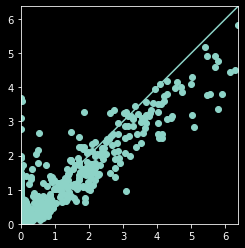

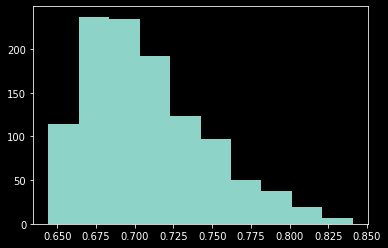

out-domain
R^2 score: 0.2686604127453668
rmse 0    1.43986
dtype: float64
R^2 score / std: 0    0.855184
dtype: float64
Uncertainty mean: 0.9188427701011741 std: 0.08150430200002626


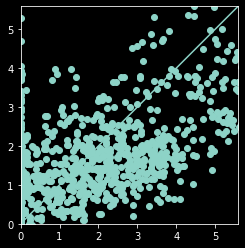

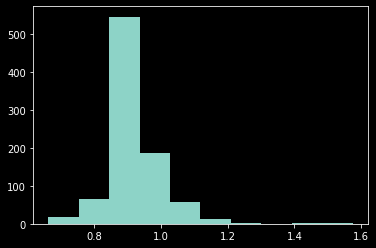

all
R^2 score: 0.5884950433913398
rmse 2.008990895135029
R^2 score / std: 1.2533253086297673
Uncertainty mean: 0.8015878786963428 std: 0.12174771314067474


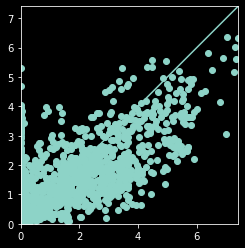

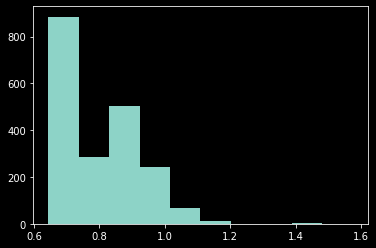

In [24]:
test_domain(comp_zip_y, n = 2000, element = ["O"], threshold = 0, min_train_group = 500)

Dropping 5/440 generated columns due to missing values
Start fitting
Done. Time for GPR fitting: 10.804
in-domain
R^2 score: 0.9725722119056828
rmse 0    0.229275
dtype: float64
R^2 score / std: 0    0.165613
dtype: float64
Uncertainty mean: 0.5098877312045289 std: 0.020798127351191107


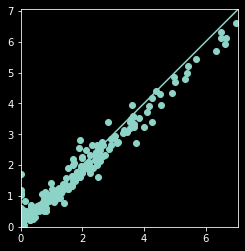

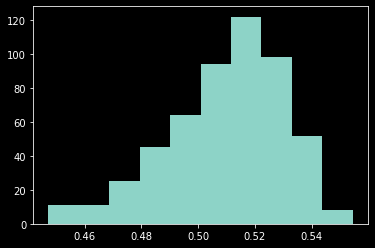

out-domain
R^2 score: 0.015585743198176183
rmse 0    1.656054
dtype: float64
R^2 score / std: 0    0.992177
dtype: float64
Uncertainty mean: 0.9056847644232626 std: 0.12361045402605385


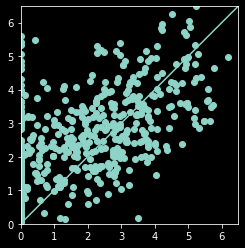

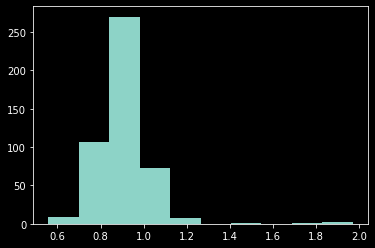

all
R^2 score: 0.521185139525478
rmse 2.3484649271108036
R^2 score / std: 1.4161227081760304
Uncertainty mean: 0.6959123368173337 std: 0.2154842845069195


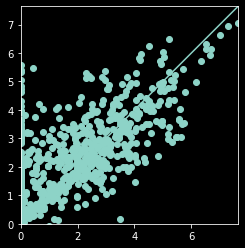

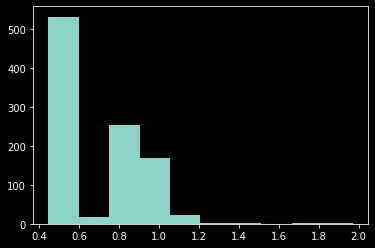

In [25]:
test_domain(comp_zip_y, n = 1000, element = ["O"], threshold = 0, min_train_group = 500)

Initial test of groupings.

In [ ]:

# !!!Warning!!! This will take about 40 minutes to run
# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
for element in material_group_char:
    print("="*10)
    print(element)
    test_domain(comp_zip_y, n = 2000, element = element, threshold = 0, min_train_group = 500)
    print("="*10)

Setup ptable groupings

In [27]:
def str_to_arr(s: str) -> list:
    """Takes in a string list (delim by ',') and returns string array"""
    x = [x.strip() for x in s.split(",")]
    return x

# Alkali metals
alkali_metals = "Li, Na, K, Rb, Cs, Fr"
alkali_metals = str_to_arr(alkali_metals)
# Alkaline earth metals
alkali_earth_metals = "Be, Mg, Ca, Sr, Ba, Ra"
alkali_earth_metals = str_to_arr(alkali_earth_metals)
# Lanthanoids
lanthanoids = "La, Ce, Pr, Nd, Pm, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu"
lanthanoids = str_to_arr(lanthanoids)
# Transition Metalis
transition_metals = "Sc, Ti, V, Cr, Mn, Fe, Co, Ni, Cu, Zn, Y, Zr, Nb, Mo, Tc, Ru, Rh, Pd, Ag, Cd, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Rf, Db, Sg, Bh, Hs"
transition_metals = str_to_arr(transition_metals)
# Post-transition metals
post_transition_metals = "Al, Ga, In, Sn, Tl, Pb, Bi, Po"
post_transition_metals = str_to_arr(post_transition_metals)
# Metaloids
metaloids = "B, Si, Ge, As, Sb, Te, At"
metaloids = str_to_arr(metaloids)
# Reactive nonmetals
reactive_nonmetals = "H, C, N, O, F, P, S, Cl, Se, Br, I"
reactive_nonmetals = str_to_arr(reactive_nonmetals)

ptable_groups = [alkali_metals, alkali_earth_metals, lanthanoids, transition_metals, post_transition_metals, metaloids, reactive_nonmetals]

# Leave these elements out of groups because they are chemically distinct
chem_distinct = ["O", "B", "F", "Cl", "Br", "I"]

for i, g in enumerate(ptable_groups):
    ptable_groups[i] = [e for e in g if e not in chem_distinct]

print(*ptable_groups, sep="\n")

['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr']
['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra']
['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Rf', 'Db', 'Sg', 'Bh', 'Hs']
['Al', 'Ga', 'In', 'Sn', 'Tl', 'Pb', 'Bi', 'Po']
['Si', 'Ge', 'As', 'Sb', 'Te', 'At']
['H', 'C', 'N', 'P', 'S', 'Se']


group: ['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr']
Create valid subsets
Iteration 0 of trying to make valid subset at size (n=2200) with length g1/g2=2000/0 threshold=0.1 num_match=1
Iteration 5 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=2
Iteration 10 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=3
Iteration 15 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=4
Iteration 20 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=5
Iteration 25 of trying to make valid subset at size (n=2500) with length g1/g2=2490/10 threshold=0.1 num_match=6
End on iteration 26 of trying to make valid subset at size (n=2500) with length g1/g2=1967/533 threshold=0.1 num_match=6
Vectorize
Dropping 5/440 generated columns due to missing values
Featurize
Training
Start fitting
Done. Time for GPR fitting: 188.937
in-domain


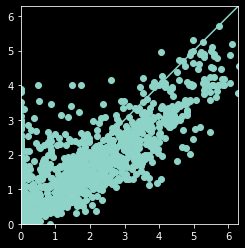

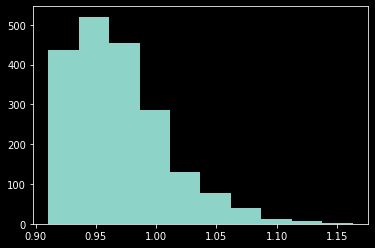

out-domain
R^2 score: 0.41877421165590956
rmse 0    1.30932
dtype: float64
R^2 score / std: 0    0.762382
dtype: float64
Uncertainty mean: 0.9960264611095576 std: 0.07016063450230162


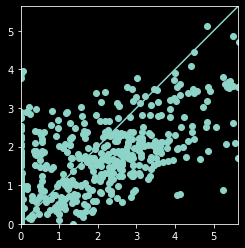

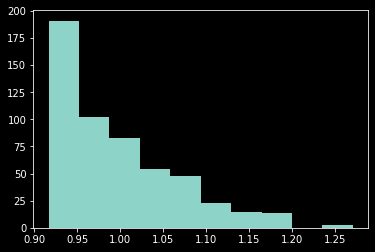

all
R^2 score: 0.6627664274045557
rmse 2.024993360013927
R^2 score / std: 1.2493374480344577
Uncertainty mean: 0.9749721508597357 std: 0.049428730739199525


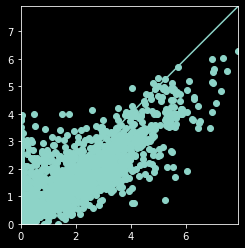

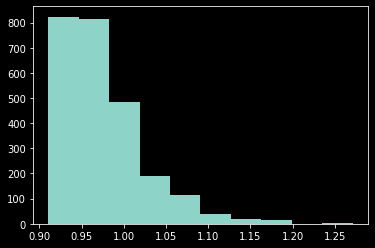

group: ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra']
Create valid subsets
Iteration 0 of trying to make valid subset at size (n=2200) with length g1/g2=2000/0 threshold=0.1 num_match=1
Iteration 5 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=2
Iteration 10 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=3
Iteration 15 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=4
Iteration 20 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=5
Iteration 25 of trying to make valid subset at size (n=2500) with length g1/g2=2491/9 threshold=0.1 num_match=6
End on iteration 26 of trying to make valid subset at size (n=2500) with length g1/g2=2183/317 threshold=0.1 num_match=6
Vectorize
Dropping 5/440 generated columns due to missing values
Featurize
Training
Start fitting
Done. Time for GPR fitting: 254.610
in-domain


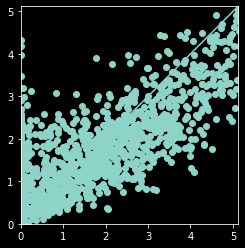

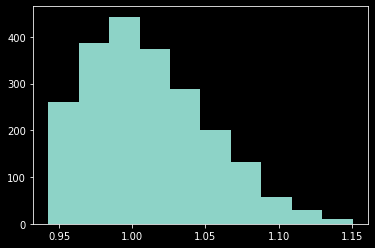

out-domain
R^2 score: 0.5092914461639936
rmse 0    1.204699
dtype: float64
R^2 score / std: 0    0.700506
dtype: float64
Uncertainty mean: 1.0404372319876674 std: 0.06643350918428662


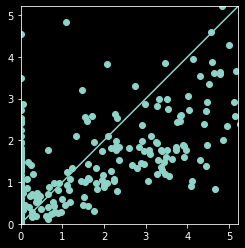

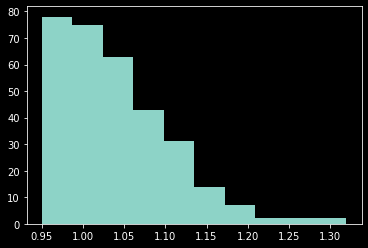

all
R^2 score: 0.6862384258308027
rmse 2.0035408127520147
R^2 score / std: 1.2540643344917033
Uncertainty mean: 1.014639542567822 std: 0.04576884853498638


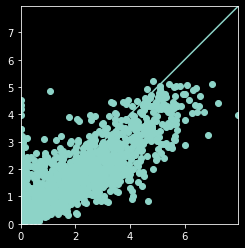

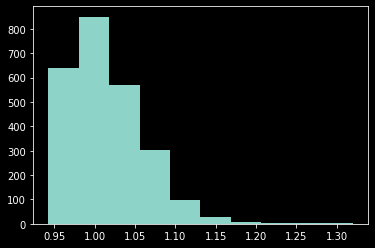

group: ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
Create valid subsets
Iteration 0 of trying to make valid subset at size (n=2200) with length g1/g2=2000/0 threshold=0.1 num_match=1
Iteration 5 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=2
Iteration 10 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=3
Iteration 15 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=4
Iteration 20 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=5
Iteration 25 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=6
Iteration 30 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1 num_match=7
Iteration 35 of trying to make valid subset at size (n=2500) with length g1/g2=2500/0 threshold=0.1

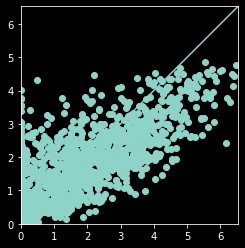

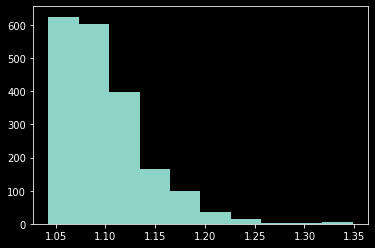

out-domain
R^2 score: 0.4765834993077792
rmse 0    0.92387
dtype: float64
R^2 score / std: 0    0.723475
dtype: float64
Uncertainty mean: 1.1255514189135152 std: 0.055241551169204865


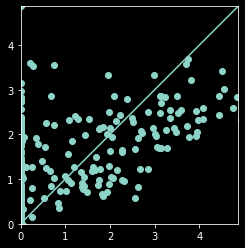

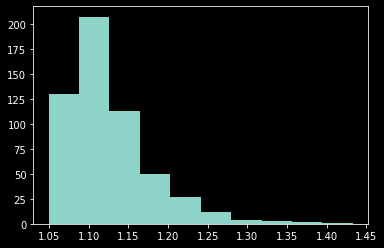

all
R^2 score: 0.6416098676806157
rmse 1.9971759076281226
R^2 score / std: 1.2511470051729778
Uncertainty mean: 1.1042870661925466 std: 0.047593763570101394


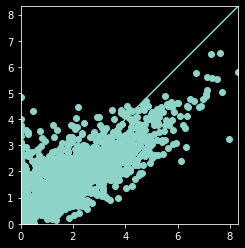

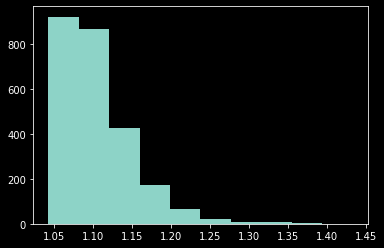

In [65]:

# TODO: Run on multiple random subsets and aggregate results
for i, group in enumerate(ptable_groups):
    print("="*10)
    print(f"group: {group}")
    test_domain(comp_zip_y, n=2000, element=group, threshold=0.1, min_train_group=300, min_test_group=300, max_n=2500, dynamic_threhold=False, dynamic_match=True)
    print("="*10)
    if i > 1:  # Only for testing
        break


## OLD CODE

In [ ]:
# list(x.items())
# print(*x.items(), sep="\n")
# print(x.iloc[0])

## verify rows sum to 1
# total = x.sum(axis=1, numeric_only= True)
# print("total", total)

# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
thresholds = [0]
for mat in material_group_char:
    continue
    print("Grouping for", mat)
    st1 = 100
    st2 = 10

    for th in thresholds:
        # Make split
        group_X = x[x[mat] > th]
        not_group_X = x[x[mat] <= th]
        # group_y = [None for x in group_X]
        # not_group_y = [None for x in not_group_y]
        group_y = y[x[mat] > th]
        not_group_y = y[x[mat] <= th]

        perc_in_group = group_X.shape[0]/x.shape[0]
        print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
        # if the split leaves an empty group skip
        if perc_in_group == 0:
            continue

        # group_X.iloc(100)
        group_X = np.array(group_X)
        group_y = np.array(group_y)

        group_X = group_X[0:1000,:]
        group_y = group_y[0:1000,:]
        
        # do GPR stuff
        print(f"Doing GPR for {mat}")
        # gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) 
        gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
        print("gpr:", gpr)
        # break
        stime = time.time()
        print("Start fitting")
        # gpr.fit(group_X, group_y)
        print("Time for GPR fitting: %.3f" % (time.time() - stime))
        print("Done")

        x_, std_ = gpr.predict(group_X, return_std=True)
        print("x_", x_)
        print("std_", std_)

        # Predict using gaussian process regressor
        # stime = time.time()
        # y_gpr = gpr.predict(X_plot, return_std=False)
        # print("Time for GPR prediction: %.3f" % (time.time() - stime))

# gpr.kernel_
# np.std(group_X)